In [1]:
import pandas as pd
import scipy.stats.distributions as dist
import numpy as np
import json
import matplotlib.pyplot as plt
import warnings
from copulas.visualization import *

from statsmodels.distributions.copula.api import *

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/mfs.csv', parse_dates=['date'], index_col='date', dayfirst=True)
df = df.resample('W', convention='end').apply({k: 'last' for k in df.columns}).drop(columns=['liquid'])
df = df.pct_change().dropna()
df.describe(percentiles=[])

,largecap,midcap,smallcap,gold
count,573.000000,573.000000,573.000000,573.000000
mean,0.003090,0.004005,0.004969,0.001210
std,0.021234,0.022879,0.026667,0.016793
min,-0.113771,-0.124562,-0.149438,-0.085875
50%,0.003853,0.005189,0.006473,0.000461
max,0.130244,0.089973,0.112077,0.087009


In [3]:
marginal_params = [dist.t.fit(df[col], floc=df[col].mean()) for col in df.columns]
marginals = [dist.t(params[0]-1, loc=params[1], scale=params[2]) for params in marginal_params]

In [4]:
copula = GaussianCopula(k_dim=len(df.columns), corr=df.corr())
copula.fit_corr_param(df.corr())

array([[ 1.       ,  0.5      ,  0.       , -0.5      ],
       [ 0.5      ,  1.       ,  0.8660254, -1.       ],
       [ 0.       ,  0.8660254,  1.       , -0.8660254],
       [-0.5      , -1.       , -0.8660254,  1.       ]])

In [5]:
model = CopulaDistribution(marginals=marginals, copula=copula)

In [6]:
df_sim = pd.DataFrame(model.rvs(10000), columns=df.columns)

In [7]:
df_sim.describe()

,largecap,midcap,smallcap,gold
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.002687,0.003690,0.004731,0.001066
std,0.022831,0.024075,0.029297,0.018385
min,-0.195261,-0.126773,-0.296701,-0.178978
25%,-0.009760,-0.010277,-0.011048,-0.008342
50%,0.002422,0.003645,0.004647,0.001067
75%,0.015056,0.017325,0.020098,0.010361
max,0.263538,0.301694,0.431151,0.232493


In [16]:
compare_1d(df['smallcap'], df_sim['smallcap'])

In [9]:
compare_2d(df_sim[['midcap', 'largecap']],df[['midcap', 'largecap']])

In [10]:
def portfolio_value_at_risk(returns, weights, alpha):
    portfolio_returns = (returns * weights).sum(axis=1)
    return -1 * portfolio_returns.quantile(alpha)


def mean_portfolio_returns(returns, weights):
    portfolio_returns = (returns * weights).sum(axis=1)
    return portfolio_returns.mean()


def get_weights(n):
    weights = np.random.random(n)
    weights /= np.sum(weights)
    return weights


def efficient_frontier(returns, n, alpha):
    # Initialize a list of json of returns, risks and weights
    portfolio = []

    # Get the number of assets in the portfolio
    n_assets = returns.shape[1]

    # Generate the portfolios and calculate the returns and VaRs
    for i in range(n):
        # Get random weights
        weights = get_weights(n_assets)

        # Calculate the mean returns
        mean_returns = mean_portfolio_returns(returns, weights)

        # Calculate the VaR
        var = portfolio_value_at_risk(returns=returns, weights=weights, alpha=alpha)

        # Append the returns and VaRs to the lists
        portfolio.append({
            'returns': mean_returns,
            'var': var,
            'weights': weights
        })
    
    df = pd.DataFrame(portfolio)
    df['annual_returns'] = (df['returns'] + 1) ** 52 - 1
    df['annual_var'] = (df['var']) * (52 ** 0.5)
    

    return df

In [17]:
portfolios_df = efficient_frontier(df_sim, 10000, alpha=0.10)

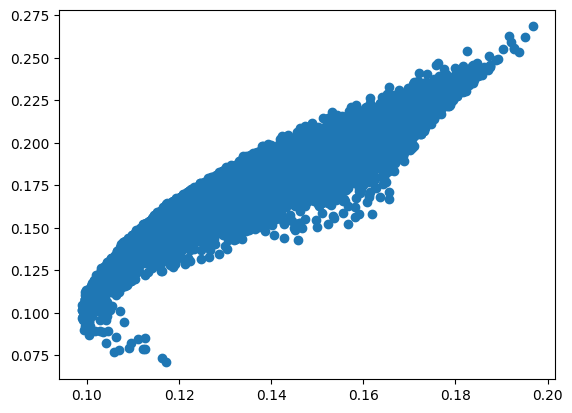

In [27]:
plt.scatter(portfolios_df['annual_var'], portfolios_df['annual_returns'])
plt.show()

In [34]:
var = 0.18
row = portfolios_df[portfolios_df['annual_var'] <= var].sort_values(by='annual_returns', ascending=False).head(1)

In [35]:
returns = row.annual_returns.values[0]
var = row.annual_var.values[0]
weights = row.weights.values[0]
historical_returns = (1+df.mean(axis=0).values)**52 - 1

In [36]:
print(f'Annual Returns: {returns}')
print(f'Annual VaR: {var}')
print(f'Weights:')
print(json.dumps((dict(zip(df.columns, weights))),indent=4))
print(f"Historical returns with same weights: {(weights* historical_returns).sum()}")

Annual Returns: 0.24671559447070002
Annual VaR: 0.1761297499439385
Weights:
{
    "largecap": 0.012257285305196907,
    "midcap": 0.050298123810194544,
    "smallcap": 0.8272907503896345,
    "gold": 0.11015384049497404
}
Historical returns with same weights: 0.26412888921199174
